In [26]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import time
from IPython import display

print(tf.__version__)

2.0.0


In [27]:
mnist = keras.datasets.mnist
(train_images,train_labels),(_,_) = mnist.load_data()
print(train_images.shape)# need to check data shape

(60000, 28, 28)


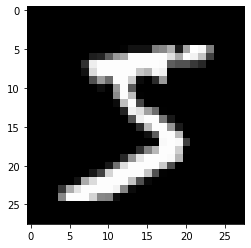

In [28]:
plt.imshow(train_images[0], cmap="gray")

In [29]:
train_images = train_images.astype('float32')
train_images = (train_images-127.5)/127.5 # GAN requries inputdata regulaization, gray scale vale range(0 ~ 255)

In [30]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [31]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images.reshape(train_images.shape[0],784)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)#make data batch and suffle

In [32]:
def G_Model():
    model = keras.Sequential([
        keras.layers.Dense(128,use_bias=False,input_shape=(100,)),
        keras.layers.LeakyReLU(0.01),
        keras.layers.Dense(128),
        keras.layers.LeakyReLU(0.01),
        keras.layers.Dense(256),
        keras.layers.LeakyReLU(0.01),
        keras.layers.Dense(784,activation="tanh")
    ])
    return model

In [33]:
def D_Model():
    model = keras.Sequential([
        keras.layers.Dense(784),
        keras.layers.LeakyReLU(0.01),
        keras.layers.Dense(256),
        keras.layers.LeakyReLU(0.01),
        keras.layers.Dense(128),
        keras.layers.LeakyReLU(0.01),
        keras.layers.Dense(128),
        keras.layers.LeakyReLU(0.01),
        keras.layers.Dense(1) # true or false
    ])
    return model

In [34]:
G = G_Model()

noise = tf.random.normal([1,100])
generated_image = G(noise, training=False)

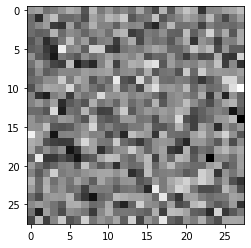

In [35]:
plt.imshow(tf.reshape(generated_image,shape=(28,28)),cmap='gray')

In [36]:
D = D_Model()
result = D(generated_image)
print(result) # result < 0 : fake result >0  not fake

tf.Tensor([[-0.14995465]], shape=(1, 1), dtype=float32)


In [37]:
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True) # optimizer

In [38]:
def G_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)

def D_loss(real_output,fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [39]:
G_optimizer = keras.optimizers.Adam(1e-4)
D_optimizer = keras.optimizers.Adam(1e-4)

In [40]:
#train
epochs = 200
noise_dim = 100
generate_example = 16

noise = tf.random.normal([generate_example,noise_dim])

In [41]:
def train_step(images):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        noise = tf.random.normal([BATCH_SIZE,noise_dim])
        G_image = G(noise,training=True)
        
        real_output = D(images,training=True)
        fake_output = D(G_image,training=True)
        
        gen_loss = G_loss(fake_output)
        disc_loss = D_loss(real_output,fake_output)
        
    gradient_of_g = gen_tape.gradient(gen_loss,G.trainable_variables)
    gradient_of_d = disc_tape.gradient(disc_loss,D.trainable_variables)
    
    G_optimizer.apply_gradients(zip(gradient_of_g, G.trainable_variables))
    D_optimizer.apply_gradients(zip(gradient_of_d, D.trainable_variables))

In [42]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            train_step(image_batch)
        display.clear_output(wait=True)
        generate_images(G,epoch,noise)
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


In [43]:
def generate_images(model, epoch, test_input):
    generated_image = model(test_input, training=False)
    generated_image = tf.reshape(generated_image,shape=(generate_example,28,28,1))
    fig = plt.figure(figsize=(4,4))
    for i in range(generated_image.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated_image[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.show()

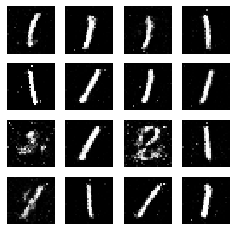

Time for epoch 50 is 5.493242263793945 sec


In [50]:
train(train_dataset,epochs)

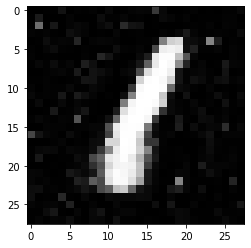

In [51]:
fake_image = G(np.random.uniform(-1,1, size = (1, 100)))
plt.imshow(tf.reshape(fake_image, shape = (28,28)), cmap="gray")